## Init

In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
base = os.path.basename(os.getcwd())
list = os.getcwd().split(os.sep) 
list.pop(list.index(base))
ROOT = '\\'.join(list)
print(ROOT)
DATA_PATH = os.path.join(ROOT, 'datasets\\preprocessed')

SEED = 42

C:\Users\giorg\Documents\GitHub\miRNA_&_mRNA


In [5]:
dataset = pd.read_csv(os.path.join(DATA_PATH, 'clinical_miRNA_normalized_log.csv'))

In [6]:
print(dataset.shape)
print(dataset.columns)
# print(dataset.head())
print(type(dataset.iloc[0]['days_to_death']))

(760, 1896)
Index(['days_to_death', 'age_at_initial_pathologic_diagnosis',
       'days_to_last_followup', 'Death', 'pathologic_stage_Stage I',
       'pathologic_stage_Stage IA', 'pathologic_stage_Stage IB',
       'pathologic_stage_Stage II', 'pathologic_stage_Stage IIA',
       'pathologic_stage_Stage IIB',
       ...
       'hsa-mir-941-5', 'hsa-mir-942', 'hsa-mir-943', 'hsa-mir-944',
       'hsa-mir-95', 'hsa-mir-9500', 'hsa-mir-96', 'hsa-mir-98', 'hsa-mir-99a',
       'hsa-mir-99b'],
      dtype='object', length=1896)
<class 'numpy.float64'>


## Hyper-parameters

In [7]:
num_folds = 15

# Note: don't use too high number of folds for small datasets, as the training sets will be very small and BatchNorm1d layer will not work properly.

## Data

In [8]:
unique, count = np.unique(dataset['age_at_initial_pathologic_diagnosis'], return_counts=True)
to_drop = [unique[u] for u in range(len(unique)) if count[u] < 5]
print(to_drop)
print(dataset.shape)

dataset=dataset[~dataset['age_at_initial_pathologic_diagnosis'].isin(to_drop)]
print(dataset.shape)

[np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(32), np.int64(83), np.int64(85), np.int64(86), np.int64(88), np.int64(89)]
(760, 1896)
(739, 1896)


In [10]:
y_cols = ['Death', 'days_to_death', 'days_to_last_followup']
X_cols = [col for col in dataset.columns if col not in y_cols]

custom_dtype = np.dtype([
    ('death', np.bool_),
    ('days', np.float64)
])

y = []
for index,row in dataset[y_cols].iterrows():
    if row['Death'] == 1:
        y.append(np.array((True, row['days_to_death'].item()), dtype=custom_dtype))
    elif row['Death'] == 0:
        tuple = (False, row['days_to_last_followup'].item())
        y.append(np.array(tuple, dtype=custom_dtype)) 
y = np.array(y)

X = dataset[X_cols]
# remove columns with zero-variance
X = X.loc[:, X.var() != 0]

## Z-scaling

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [20]:
y = y['days']

In [12]:
y_log = np.log10(y["days"] + 1e-6)

## Data splitting

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(scaled_X, y_log, test_size=0.2)
#X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, stratify=X['age_at_initial_pathologic_diagnosis'])

In [23]:
print("y_train mean/std:", np.mean(y_train), np.std(y_train))
print("y_test mean/std:", np.mean(y_test), np.std(y_test))

y_train mean/std: 842.2571912013536 1004.641669842194
y_test mean/std: 595.2094594594595 802.5649443568531


In [24]:
print("y_train_log mean/std:", np.mean(y_train_log), np.std(y_train_log))
print("y_test_log mean/std:", np.mean(y_test_log), np.std(y_test_log))

y_train_log mean/std: 2.0632576405753627 2.130772429994281
y_test_log mean/std: 2.108662697064779 1.9566734079905264


## K-fold

In [25]:
from sklearn.model_selection import KFold, StratifiedKFold

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)
#kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Linear MLP

In [26]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score

import torch
torch.manual_seed(0)

## Plots

In [27]:
def plot_real_vs_predicted(trues, preds):
    trues_flat = trues.flatten()
    preds_flat = preds.flatten()
    errors = preds_flat - trues_flat
    
    plt.figure(figsize=(7,7))
    plt.scatter(trues_flat, preds_flat, c=np.abs(errors), cmap='viridis', alpha=0.7)
    plt.plot([trues.min(), trues.max()],
             [trues.min(), trues.max()],
             'r--', label='Perfect prediction')
    plt.colorbar(label="Absolute Error")
    plt.xlabel("Real Days to Death")
    plt.ylabel("Predicted Days to Death")
    plt.title("Predicted vs True Days to Death (colored by error)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_losses_grid(model):
    plt.figure(figsize=(10, 6))
    plt.plot(model.history[:, 'train_loss'], label='Train Loss')
    plt.plot(model.history[:, 'valid_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()

### 3-layer model

In [12]:
class MiRNANet_3(nn.Module):
    def __init__(self, input_dim, output_dim, dropout, start_lr=0.001, lr_decay=0.3, patience=15):
        super(MiRNANet_3, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(32, output_dim),
            #nn.Softmax(-1)
        )
        self.lr_decay = lr_decay
        self.patience = patience
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=start_lr)
        self.criterion = nn.L1Loss()
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',        # riduce LR quando la metrica (loss) smette di diminuire
            factor=self.lr_decay,        # dimezza il learning rate
            patience=self.patience        # aspetta 10 epoche senza miglioramenti
        )
    def forward(self, x):
        return self.model(x)   
    def loop(self, train_loader, test_loader, epochs=100):
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []
        for epoch in range(epochs):
            self.model.train()
            total_train_loss = 0
            total_train_acc = 0
            for X_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item()
                total_train_acc += accuracy_score(np.argmax(outputs.detach().numpy(), axis=1), np.argmax(y_batch, axis=1))
            
            avg_train_loss = total_train_loss / len(train_loader)
            avg_train_acc = total_train_acc / len(train_loader)
            
            self.scheduler.step(avg_train_loss)

            train_accs.append(avg_train_acc)

            self.model.eval()
            total_val_loss = 0
            total_val_acc = 0
            with torch.no_grad():
                preds = []
                trues = []
                for X_batch, y_batch in test_loader:
                    outputs = self.model(X_batch)
                    loss = self.criterion(outputs, y_batch)
                    preds.append(outputs.numpy())
                    trues.append(y_batch.numpy())
                    total_val_loss += loss.item()
                    total_val_acc += accuracy_score(np.argmax(outputs.detach().numpy(), axis=1), np.argmax(y_batch, axis=1))
                preds = np.vstack(preds)
                trues = np.vstack(trues)
            avg_val_loss = total_val_loss / len(test_loader)
            avg_val_acc = total_val_acc / len(test_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            val_accs.append(avg_val_acc)

            print(f"Epoch {epoch+1:03d}:\nTrain Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}\nTrain Acc: {avg_train_acc:.4f} | Val Acc: {avg_val_acc:.4f}")
            mae = mean_absolute_error(trues, preds)
            print(f"Test MAE: {mae:.2f}")

        model_res = {
            'params':self.model.parameters(),
            'train_losses':train_losses,
            'eval_losses': val_losses,
            'train_accs': train_accs,
            'val_accs':val_accs,
            'preds':preds,
            'trues':trues
        }

        return model_res

### 5-layer model

In [ ]:
class MiRNANet_5(nn.Module):
    def __init__(self, input_dim, output_dim, dropout):#, start_lr = 0.001):
        super(MiRNANet_5, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, output_dim)  # <--- ultimo layer lineare
        )
        self.optimizer = torch.optim.Adam(self.model.parameters())#, lr=start_lr)
        self.criterion = nn.MSELoss()
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',        # riduce LR quando la metrica (loss) smette di diminuire
            factor=0.6,        # dimezza il learning rate
            patience=15        # aspetta 10 epoche senza miglioramenti
        )
    def forward(self, x):
        return self.model(x)
    
    def loop(self, train_loader, test_loader, epochs=100):
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            self.model.train()
            total_train_loss = 0
            for X_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                # print(outputs)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item()
            
            avg_train_loss = total_train_loss / len(train_loader)
            self.scheduler.step(avg_train_loss)

            self.model.eval()
            total_val_loss = 0
            with torch.no_grad():
                preds = []
                trues = []
                for X_batch, y_batch in test_loader:
                    outputs = self.model(X_batch)
                    loss = self.criterion(outputs, y_batch)
                    preds.append(outputs.numpy())
                    trues.append(y_batch.numpy())
                preds = np.vstack(preds)
                trues = np.vstack(trues)
                total_val_loss += loss.item()
            avg_val_loss = total_val_loss / len(test_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        model_res = {
            'params':self.model.parameters(),
            'train_losses':train_losses,
            'eval_losses': val_losses
        }

        return model_res

## Print Results

In [28]:
def print_results(preds):
    print("Metrics for log results:")
    
    mae = mean_absolute_error(y_test_mlp, preds)
    r2 = r2_score(y_test_mlp, preds)
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    
    print("Preds mean/std:", np.mean(preds), np.std(preds))

### Grid search for best parameters

#### Scoring C-Index

In [32]:
#y_fixed = np.array([row['days'] for row in y_train], dtype=np.float32)
y_fixed = np.array(y_train, dtype=np.float32)
X_mlp = X_train.values.astype(np.float32)
y_mlp = y_fixed.astype(np.float32)

#y_test_fixed = np.array([row['days'] for row in y_test], dtype=np.float32)
y_test_fixed = np.array(y_test, dtype=np.float32)
y_test_mlp = torch.tensor([row for row in y_test_fixed], dtype=torch.float32)
X_test_mlp = torch.tensor(X_test.values, dtype=torch.float32)

In [33]:
y_fixed_log = np.array(y_train_log, dtype=np.float32)
X_mlp_log = X_train_log.values.astype(np.float32)
y_mlp_log = y_fixed_log.astype(np.float32)

#y_test_fixed = np.array([row['days'] for row in y_test], dtype=np.float32)
y_test_fixed_log = np.array(y_test_log, dtype=np.float32)
y_test_mlp_log = torch.tensor([row for row in y_test_fixed_log], dtype=torch.float32)
X_test_mlp_log = torch.tensor(X_test_log.values, dtype=torch.float32)

In [34]:
class MiRNANet_3_grid(nn.Module):
    def __init__(self, input_dim, output_dim, hidden1, hidden2, dropout):
        super(MiRNANet_3_grid, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden1),
            nn.Dropout(dropout),
            
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden2, output_dim),
        )
        
    def forward(self, x):
        return self.model(x).squeeze(-1)

In [35]:
from skorch import NeuralNetRegressor
from skorch.callbacks import LRScheduler, EarlyStopping
from sklearn.metrics import make_scorer
from lifelines.utils import concordance_index
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

def cindex_scorer(y_true, y_pred):
    return concordance_index(y_true, -y_pred.ravel())

cindex = make_scorer(cindex_scorer, greater_is_better=True)


# GRID SEARCH
net = NeuralNetRegressor(
    module=MiRNANet_3_grid, # MiRNANet_3,
    module__input_dim=X_mlp.shape[1], #X_train_mlp.shape[1],
    module__output_dim=1, #y_train_mlp.shape[1],
    max_epochs=60,
    lr=1e-2,
    batch_size=32,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-6,
    criterion=nn.MSELoss(), #nn.MSELoss(),# CoxPHLoss(), # nn.SmoothL1Loss(beta=beta_value), #nn.L1Loss(),
    callbacks=[
         ('lr_scheduler', LRScheduler(
             ReduceLROnPlateau, 
             mode='min', 
             factor=0.7, 
             patience=10, 
             monitor='valid_loss',
             min_lr=1e-6
         )),
        ('early_stopping', EarlyStopping(
             monitor='valid_loss',
             patience=20,
             threshold=1e-4,
             threshold_mode='rel',
             load_best=True
        ))
    ],
)
"""params = {    
    'module__hidden1': [64, 128, 256, 512],
    'module__hidden2': [32, 64, 128, 256],
    'module__dropout': [0.1, 0.25, 0.4],  
    'optimizer': [torch.optim.Adam, torch.optim.AdamW],
    'optimizer__weight_decay': [0, 1e-6, 1e-5, 1e-4],
    'callbacks__lr_scheduler__factor': [0.8, 0.6, 0.4],
    'callbacks__lr_scheduler__patience': [5, 10, 15],
    'callbacks__early_stopping__patience': [15, 25],
    'callbacks__early_stopping__threshold': [1e-3, 1e-4],
    'lr': [1e-2, 5e-3, 1e-3],    
    'max_epochs': [60, 100, 150],
    'batch_size': [32, 64, 128],
}"""

params = {    
    'module__hidden1': [64],
    'module__hidden2': [32],
    'module__dropout': [0.1],
    'lr': [5e-3],
}

#gs = GridSearchCV(
rs = RandomizedSearchCV(
    net,
    params,
    n_iter=40,
    refit=True, 
    cv=kfold, # cross-validation folds
    scoring=cindex, # If MSE Loss, comment this line
    verbose=1,
    n_jobs=1,
    random_state=SEED
)

In [36]:
rs.fit(X_mlp, y_mlp.reshape(-1))

best_model = rs.best_estimator_
print("Best hyperparameters:", rs.best_params_)
print("Best C-index:", rs.best_score_)

c:\users\giorg\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=40. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 15 folds for each of 1 candidates, totalling 15 fits
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1  1684911.9341  1833846.9099  0.0050  0.1140
      2  1676328.1091  1823001.9279  0.0050  0.0708
      3  1650668.9364  1795671.5000  0.0050  0.0805
      4  1586502.6068  1734983.0586  0.0050  0.0637
      5  1458180.2886  1615205.0360  0.0050  0.0604
      6  1246658.5102  1456442.3581  0.0050  0.0709
      7   989146.5352  1289419.7613  0.0050  0.0759
      8   683569.9401  1165211.2455  0.0050  0.0709
      9   458048.8705  1104748.1036  0.0050  0.0743
     10   265897.5211  1098162.7252  0.0050  0.0733
     11   160752.4999  1135045.1014  0.0050  0.0722
     12   134127.4258  1124207.2477  0.0050  0.0754
     13   118868.2624  1116406.9842  0.0050  0.0791
     14   106336.1904  1105119.6892  0.0050  0.0797
     15    81763.4225  1144429.4662  0.0050  0.0860
     16    79168.5163  1112295.5946  0.0050  0.0808
   

In [37]:
rs_log = RandomizedSearchCV(
    net,
    params,
    n_iter=40,
    refit=True, 
    cv=kfold, # cross-validation folds
    scoring=cindex, # If MSE Loss, comment this line
    verbose=1,
    n_jobs=1,
    random_state=SEED
)

rs_log.fit(X_mlp_log, y_mlp_log.reshape(-1))

best_model_log = rs_log.best_estimator_
print("Best hyperparameters:", rs_log.best_params_)
print("Best C-index:", rs_log.best_score_)

Fitting 15 folds for each of 1 candidates, totalling 15 fits
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1        6.3644        3.8672  0.0050  0.0931
      2        3.5018        3.2092  0.0050  0.0716


c:\users\giorg\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=40. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


      3        2.2475        3.4816  0.0050  0.0605
      4        0.9003        4.7193  0.0050  0.0868
      5        0.7236        4.6242  0.0050  0.0888
      6        0.4889        4.7381  0.0050  0.0821
      7        0.4283        4.5678  0.0050  0.0659
      8        0.4062        4.4494  0.0050  0.0588
      9        0.3289        4.4251  0.0050  0.0626
     10        0.3302        4.5950  0.0050  0.0728
     11        0.3281        4.6078  0.0050  0.0645
     12        0.2502        4.5431  0.0050  0.0736
     13        0.3058        4.2701  0.0050  0.0670
     14        0.2917        4.5775  0.0035  0.0732
     15        0.1979        4.7055  0.0035  0.0610
     16        0.1938        4.7353  0.0035  0.0624
     17        0.2213        4.7494  0.0035  0.0681
     18        0.1963        4.7343  0.0035  0.0647
     19        0.2101        4.6487  0.0035  0.0627
     20        0.2138        4.7082  0.0035  0.0721
     21        0.1988        4.6528  0.0035  0.0632
Stopping sin

In [38]:
preds = best_model.predict(X_test_mlp)
print_results(preds)

Metrics for log results:
MAE: 651.90
R²: -0.09
Preds mean/std: 884.14233 429.96533


In [39]:
preds_log = best_model_log.predict(X_test_mlp_log)
print_results(preds_log)

Metrics for log results:
MAE: 593.54
R²: -0.55
Preds mean/std: 1.9861941 0.64145494


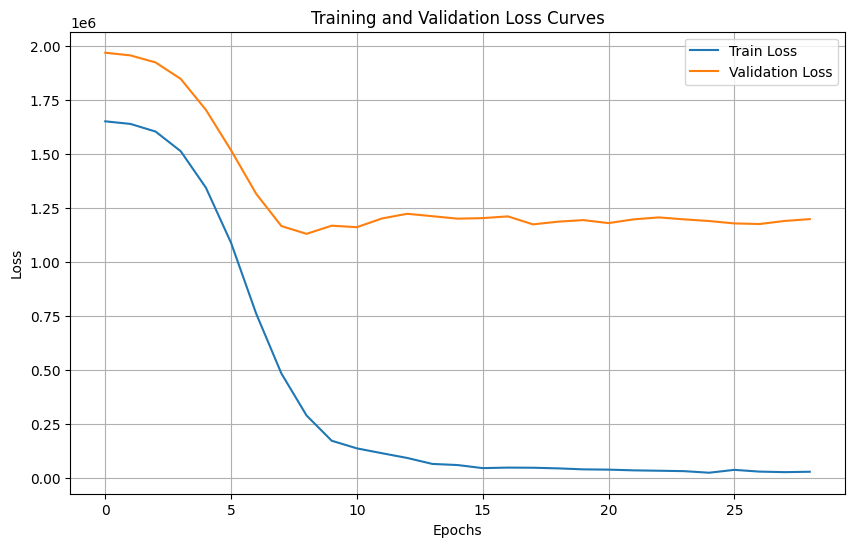

In [41]:
plot_losses_grid(best_model)

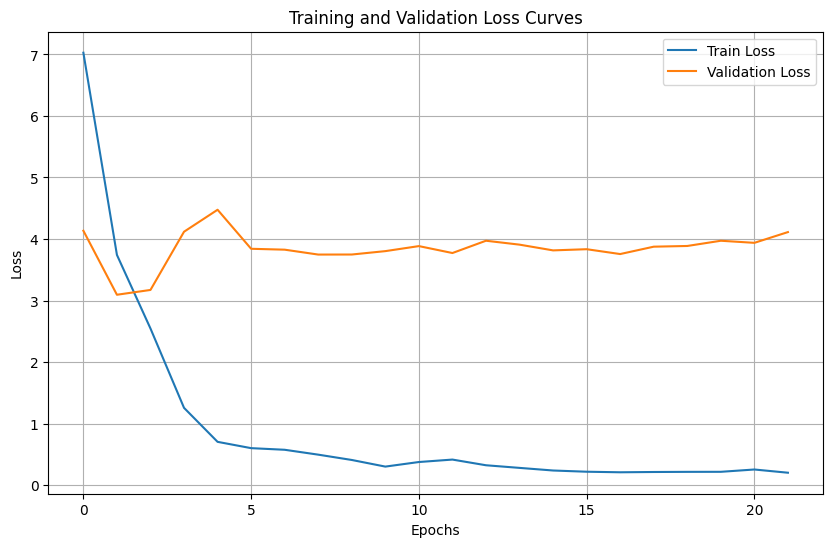

In [40]:
plot_losses_grid(best_model_log)

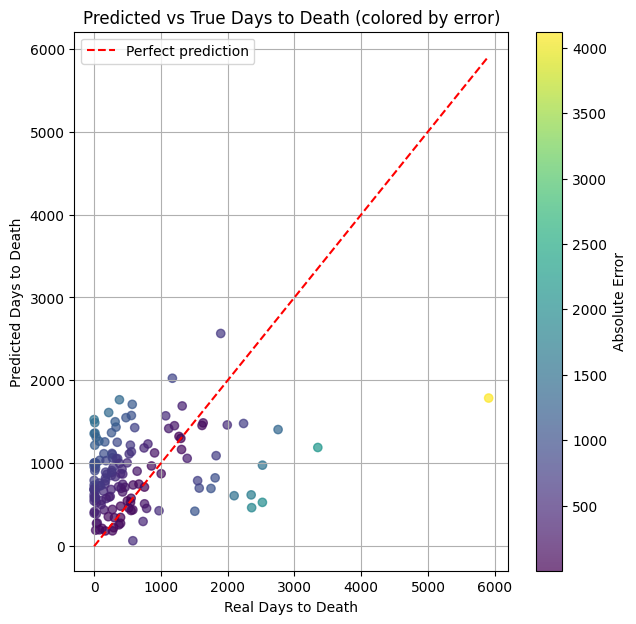

In [42]:
plot_real_vs_predicted(y_test_fixed, preds)

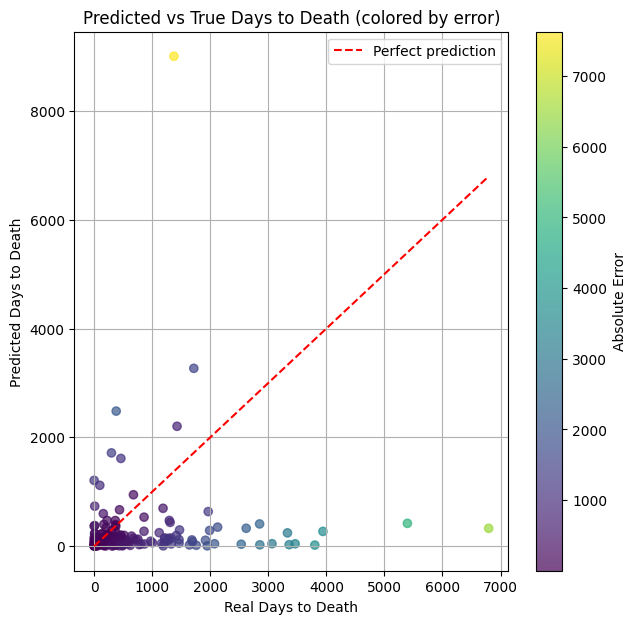

In [43]:
plot_real_vs_predicted(10**y_test_fixed_log, 10**preds_log)

## MLP 5 

In [44]:
class MiRNANet_5_grid(nn.Module):
    def __init__(self, input_dim, output_dim, dropout):
        super(MiRNANet_5_grid, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.model(x).squeeze(-1)

In [46]:
from skorch import NeuralNetRegressor
from skorch.callbacks import LRScheduler, EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from lifelines.utils import concordance_index
import numpy as np

# Scorer per C-index
def cindex_scorer(y_true, y_pred):
    return concordance_index(y_true, -y_pred.ravel())

cindex = make_scorer(cindex_scorer, greater_is_better=True)

net = NeuralNetRegressor(
    module=MiRNANet_5_grid,
    module__input_dim=X_mlp.shape[1],
    module__output_dim=1,
    max_epochs=60,
    lr=1e-3,
    batch_size=64,
    optimizer=torch.optim.Adam,
    criterion=nn.MSELoss(),
    iterator_train__drop_last=True,  # To ensure consistent batch sizes
    callbacks=[
        ('lr_scheduler', LRScheduler(
            ReduceLROnPlateau,
            mode='min',
            factor=0.6,
            patience=10,
            monitor='valid_loss',
            min_lr=1e-6
        )),
        ('early_stopping', EarlyStopping(
            monitor='valid_loss',
            patience=20,
            threshold=1e-4,
            threshold_mode='rel',
            load_best=True
        ))
    ],
)

"""params = {
    'module__dropout': [0.1, 0.2, 0.3, 0.4],
    'lr': [1e-2, 5e-3, 1e-3],
    'batch_size': [32, 64, 128],
    'optimizer': [torch.optim.Adam, torch.optim.AdamW],
    'optimizer__weight_decay': [0, 1e-5, 1e-4],
    'max_epochs': [80, 100, 150],
    'callbacks__lr_scheduler__factor': [0.8, 0.6, 0.4],
    'callbacks__lr_scheduler__patience': [5, 10, 15],
    'callbacks__early_stopping__patience': [10, 20, 25],
}
"""
params = {
    'module__dropout': [0.1],
    'lr': [5e-3],
}

Best hyperparameters: {'module__dropout': 0.1, 'lr': 0.005}
Best C-index: 0.4098867077205064

In [47]:
rs_5 = RandomizedSearchCV(
    net,
    params,
    n_iter=40,
    scoring=cindex,
    cv=kfold,
    refit=True,
    verbose=1,
    n_jobs=1,
    random_state=SEED
)

rs_5.fit(X_mlp, y_mlp.reshape(-1))

print("Best hyperparameters:", rs_5.best_params_)
print("Best C-index:", rs_5.best_score_)

best_model_5 = rs_5.best_estimator_

c:\users\giorg\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=40. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 15 folds for each of 1 candidates, totalling 15 fits
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1  1633587.8542  1832385.3851  0.0050  0.2257
      2  1627629.5000  1804674.2849  0.0050  0.2239
      3  1618405.4375  1811639.3345  0.0050  0.1846
      4  1609781.8958  1803509.5980  0.0050  0.1647
      5  1600675.5625  1814768.5045  0.0050  0.1632
      6  1589848.1875  1810113.0068  0.0050  0.2012
      7  1577820.7917  1813064.2962  0.0050  0.2298
      8  1566258.3021  1808536.3626  0.0050  0.2102
      9  1551168.0729  1805679.5811  0.0050  0.2095
     10  1533927.2083  1797616.5597  0.0050  0.2492
     11  1514785.2604  1792172.7736  0.0050  0.2519
     12  1493855.9271  1779433.0811  0.0050  0.2151
     13  1470410.8333  1779781.1419  0.0050  0.2089
     14  1447121.1042  1774246.2117  0.0050  0.2158
     15  1421257.8542  1749430.9707  0.0050  0.1903
     16  1393264.8125  1708898.7466  0.0050  0.1893
   

In [48]:
rs_5_log = RandomizedSearchCV(
    net,
    params,
    n_iter=40,
    scoring=cindex,
    cv=kfold,
    refit=True,
    verbose=1,
    n_jobs=1,
    random_state=SEED
)

rs_5_log.fit(X_mlp_log, y_mlp_log.reshape(-1))

print("Best hyperparameters:", rs_5_log.best_params_)
print("Best C-index:", rs_5_log.best_score_)

best_model_5_log = rs_5_log.best_estimator_

Fitting 15 folds for each of 1 candidates, totalling 15 fits
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1        6.5802        5.8704  0.0050  0.1782
      2        3.8461       14.0805  0.0050  0.1807
      3        1.5810       15.4410  0.0050  0.1757
      4        0.8481        7.8633  0.0050  0.1672
      5        0.5874        5.8413  0.0050  0.1770
      6        0.4428        4.4975  0.0050  0.1650
      7        0.2950        3.6172  0.0050  0.1833
      8        0.3268        3.5048  0.0050  0.1711
      9        0.3106        3.5603  0.0050  0.2152
     10        0.2402        3.5828  0.0050  0.2003
     11        0.2189        3.6063  0.0050  0.1813
     12        0.2443        3.6007  0.0050  0.1787
     13        0.2038        3.5714  0.0050  0.1800
     14        0.2246        3.5431  0.0050  0.1671
     15        0.2119        3.5454  0.0050  0.1622
     16        0.1892        3.6221  0.0050  0.1710
   

In [50]:
preds = best_model_5.predict(X_test_mlp)
print_results(preds)

Metrics for log results:
MAE: 586.96
R²: -0.10
Preds mean/std: 665.0619 477.87155


In [51]:
preds_log = best_model_5_log.predict(X_test_mlp_log)
print_results(preds_log)

Metrics for log results:
MAE: 593.13
R²: -0.55
Preds mean/std: 2.5125222 0.4383161


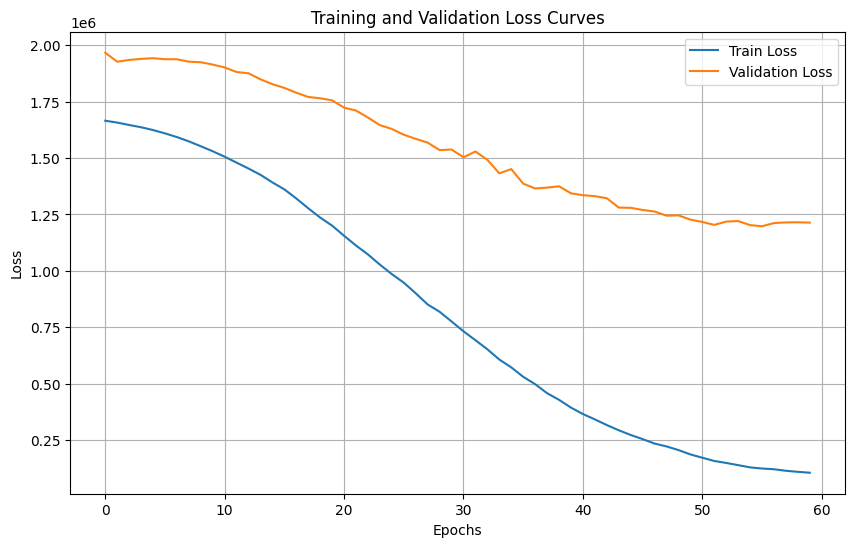

In [52]:
plot_losses_grid(best_model_5)

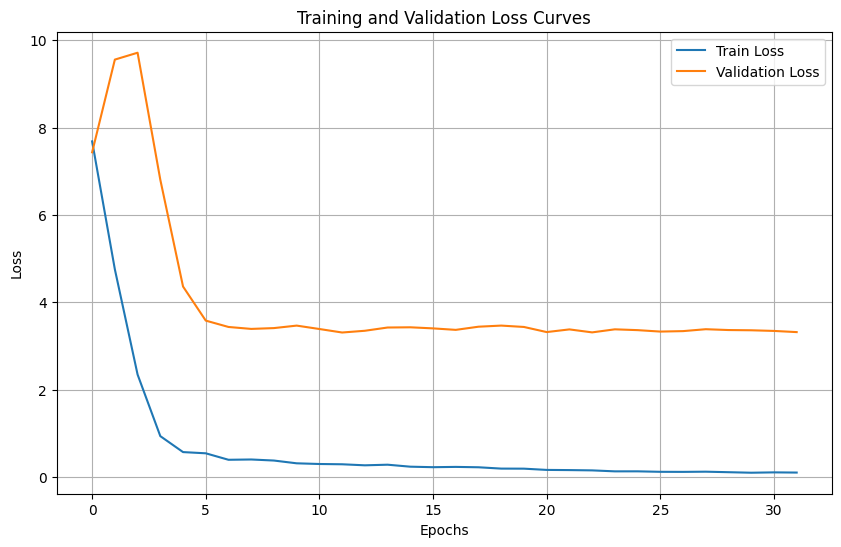

In [53]:
plot_losses_grid(best_model_5_log)

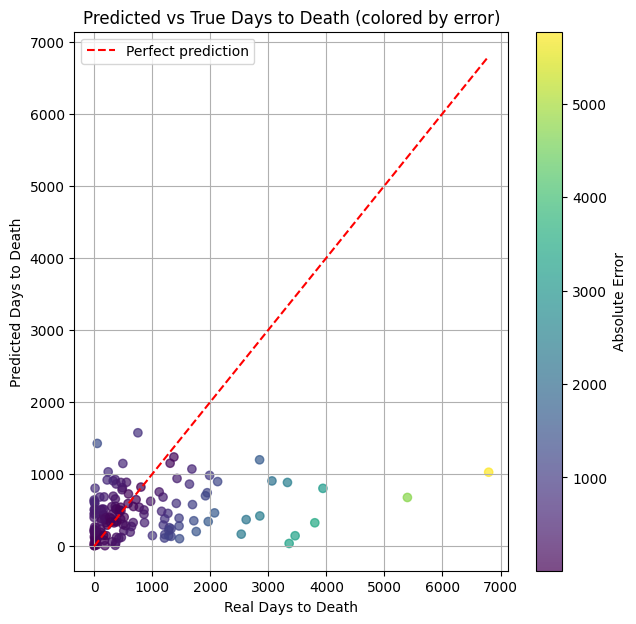

In [54]:
plot_real_vs_predicted(10**y_test_fixed_log, 10**preds_log)

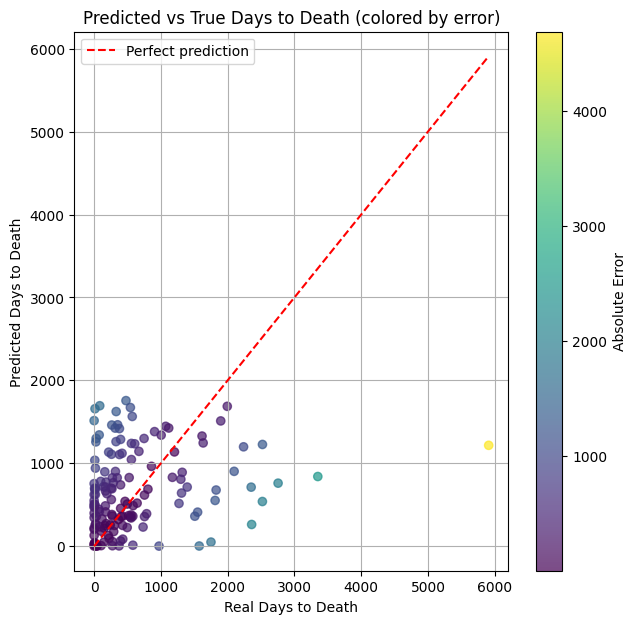

In [55]:
plot_real_vs_predicted(y_test_fixed, preds)

## Confidence interval for C-index

In [56]:
import numpy as np
from scipy import stats

def CI_Cindex(mean_scores, std_scores, n_folds):
    # Calculate 95% confidence interval for the best C-index
    best_idx = np.argmax(mean_scores)
    best_mean = mean_scores[best_idx]
    best_std = std_scores[best_idx]
    conf_int = stats.t.interval(
        0.95, df=n_folds-1,
        loc=best_mean,
        scale=best_std / np.sqrt(n_folds)
    )
    
    print(f"Best mean C-index: {best_mean:.4f}")
    print(f"95% CI: [{conf_int[0]:.4f}, {conf_int[1]:.4f}]")

In [57]:
mean_scores = rs.cv_results_['mean_test_score']
std_scores = rs.cv_results_['std_test_score']
n_folds = kfold.get_n_splits()

CI_Cindex(mean_scores, std_scores, n_folds)

Best mean C-index: 0.4446
95% CI: [0.4165, 0.4727]


In [58]:
mean_scores = rs_log.cv_results_['mean_test_score']
std_scores = rs_log.cv_results_['std_test_score']
n_folds = kfold.get_n_splits()

CI_Cindex(mean_scores, std_scores, n_folds)

Best mean C-index: 0.4303
95% CI: [0.4044, 0.4562]


In [59]:
mean_scores = rs_5.cv_results_['mean_test_score']
std_scores = rs_5.cv_results_['std_test_score']
n_folds = kfold.get_n_splits()

CI_Cindex(mean_scores, std_scores, n_folds)

Best mean C-index: 0.4116
95% CI: [0.3854, 0.4379]


In [60]:
mean_scores = rs_5_log.cv_results_['mean_test_score']
std_scores = rs_5_log.cv_results_['std_test_score']
n_folds = kfold.get_n_splits()

CI_Cindex(mean_scores, std_scores, n_folds)

Best mean C-index: 0.4152
95% CI: [0.3812, 0.4492]


# test predicting procedure for Cox MLP

In [ ]:
import torch.optim as optim

# --- 1. Definizione della MLP ---
class DeepSurvMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[32, 16], dropout=0.3):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(dims[-1], 1))  # output scalare f_theta(X)
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

# --- 2. Loss function: negative partial log-likelihood di Cox ---
def cox_partial_log_likelihood(pred, time, event):
    """
    pred: f_theta(X), shape [N, 1]
    time: tempi di follow-up, shape [N]
    event: indicatori di evento (1=evento, 0=censurato), shape [N]
    """
    pred = pred.reshape(-1)
    order = torch.argsort(time, descending=True)
    pred = pred[order]
    event = event[order]

    risk_sum = torch.logcumsumexp(pred, dim=0)
    loss = -torch.sum(pred[event==1] - risk_sum[event==1])
    return loss / event.sum()  # media sul numero di eventi

# --- 3. Simulazione dati fittizi ---
#N, D = 100, 5  # 100 soggetti, 5 covariate
torch.manual_seed(0)
#X = torch.randn(N, D)
#time = torch.rand(N) * 10
#event = torch.randint(0, 2, (N,))
X = X_mlp
time = torch.tensor([row['days'] for row in y], dtype=torch.float32)
event = torch.tensor([row['death'] for row in y], dtype=torch.float32)


# --- 4. Creazione modello e ottimizzatore ---
model = DeepSurvMLP(input_dim=X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.01)

# --- 5. Training loop semplice ---
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X)
    loss = cox_partial_log_likelihood(pred, time, event)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# --- 6. Predizione dei rischi relativi ---
model.eval()
with torch.no_grad():
    risk_scores = model(X)
    hazard_ratios = torch.exp(risk_scores)  # hazard relativo rispetto al baseline
    print("Hazard ratios:", hazard_ratios[:5].reshape(-1))
